# 🎯 Aula 8 - Dados atípicos: Outliers 🎯

Na análise de dados, a detecção e correção de outliers são essenciais para garantir a validade das observações. Outliers, que são pontos que se destacam drasticamente do restante dos dados, podem surgir devido à variabilidade natural dos dados ou a erros experimentais e de digitação. 

Tratar adequadamente os outliers é fundamental para garantir análises estatísticas precisas e confiáveis, evitando distorções nos resultados, como médias e modelos de regressão.

# Causas Comuns de Outliers
- **Erros de Medição:** Erros na coleta de dados ou falhas de equipamentos.
- **Erros de Entrada de Dados:** Erros humanos durante a entrada de dados.
- **Variação Natural:** Extrema variação natural nos dados.
- **Mudanças no Comportamento dos Dados:** Mudanças genuínas nas populações ou processos que estão sendo medidos.

# Tipos de Outliers

- **Outliers Pontuais:** São observações individuais que se destacam do resto do conjunto de dados.

- **Outliers Contextuais:** São observações que se destacam no contexto de um subconjunto específico de dados.<br>
Por exemplo, em um estudo sobre o desempenho de estudantes de diferentes escolas, uma pontuação abaixo da média em uma escola de alto desempenho pode ser considerada um outlier contextual.

- **Outliers Coletivos:** São um grupo de observações que, como um todo, se desviam do padrão geral dos dados, mas individualmente podem não ser outliers. <br>
Por exemplo, em um conjunto de dados de vendas mensais, um mês com vendas significativamente mais baixas que os outros meses pode não ser considerado um outlier individualmente, mas quando agrupado com outros meses semelhantes, forma um grupo de outliers coletivos.

# Métodos de Detecção


## Detecção de outliers por meio do desvio-padrão (Z-score)
Uma técnica comum para identificar outliers é usar o desvio-padrão. Um ponto de dados é considerado um outlier se estiver a mais de um certo número de desvios-padrão da média (normalmente 2, compreendendo de 95% dos dados -- veja a imagem abaixo).


## Cálculo do Z-score

Primeiro precisamos normalizar o conjunto de dados. Isso significa representar todos em dados em relação às propriedades da **curva normal** que pode ser escrita em termos de dois parâmetros: média ($\mu$) e desvio-padrão ($\sigma$) -- Estatísticamente escrita como $N(\mu,\sigma)$.

Para normalizar os seus dados $X$ para $N$:

$N = \frac{X - \mu}{\sigma}$

Z-score = $Z = \sigma$

Sendo:
$N$ : dados normalizados
$X$ : dados originais a serem transformados
$\mu, \sigma$ : média e desvio-padrão de $X$, respectivamente

<center><img src="http://www.eajohansson.net/wp-content/uploads/2018/07/standard-normal-distribution-curve.jpg" alt="Curva normal sample" width="400rm"></center>

Observe que, basicamente, o que estamos fazendo é centralizar nossos dados na média $\mu$ e mapear a distribuição de dados somente com o desvio padrão $\sigma$.

**Obs**: Ao realizar esta transformação, estamos assumindo que a distribuição dos dados pode ser descrita por uma curva normal, o que pode ser verdade ou não.

Vamos trazer os dados de corridas de Taxi, usando o Seaborn `load_dataset` e verificar a distribuição de passageiros por corrida (qual é o gráfico que eu ploto a  distribuição mesmo? 🤨)

<Axes: xlabel='passengers', ylabel='Count'>

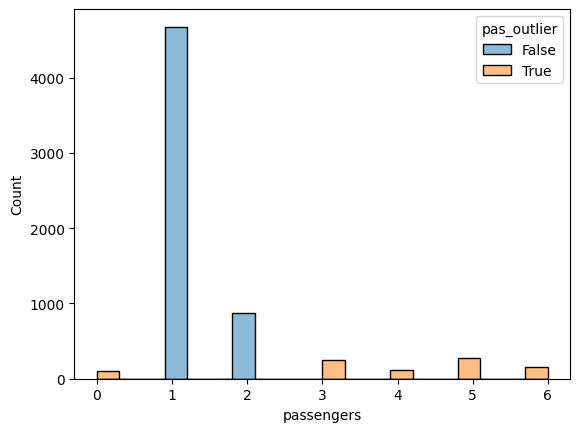

In [54]:
df = sns.load_dataset('taxis')
df['passengers'].mean(), df['passengers'].std()
dados = df['passengers']
N, media, Z = normalizar_dados(dados)
df['pas_outlier'] = (N < -Z) | (N > Z)

sns.histplot(df, x='passengers', bins=20, hue='pas_outlier')

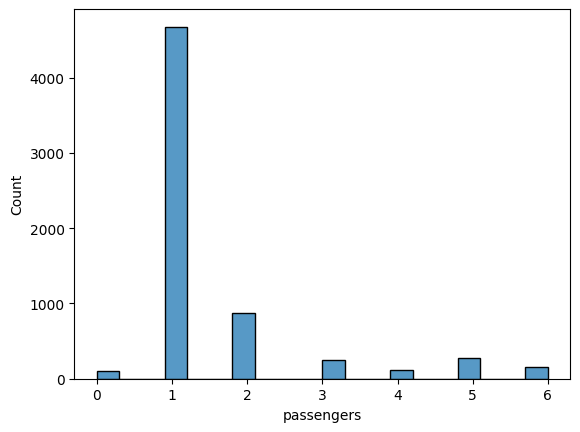

In [55]:
import seaborn as sns
import pandas as pd

# load taxi dataset
df = sns.load_dataset('taxis')

# plot distribution
sns.histplot(df, x='passengers', bins=20);

A qtd de passageiros por corrida parece um pouco com uma curva normal. Se quiséssemos encontrar os outliers desses dados então, poderíamos utilizar o `Z-score`.

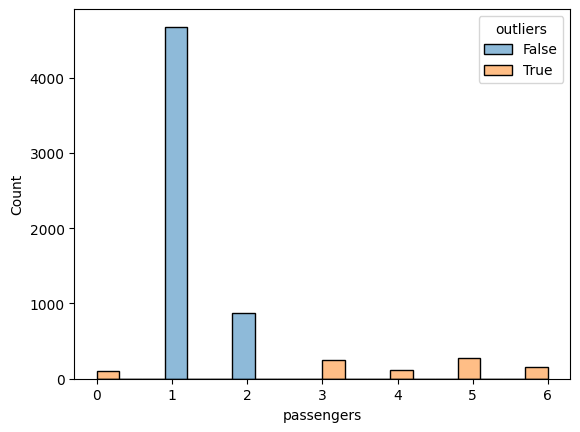

In [56]:
# função para normalizar dados
def normalizar_dados(X):
    # calcular média e desvio-padrão
    mu, sigma = X.mean(), X.std()
    N = (X-mu)/sigma
    return N, mu, sigma

passageiros = df['passengers']
N, media, Z = normalizar_dados(passageiros)

# vamos aplicar uma simples comparação 
# se os dados estão fora do limite 2 Z
df['outliers'] = (N<-Z/2) | (N>Z/2)

sns.histplot(df, x='passengers', bins=20, hue='outliers');

Podemos observar três coisas:

1. Obviamente 0 passageiros na corrida é um outlier, já que é impossível isso acontecer (mas devemos sempre nos perguntar como é a regra de negócio pra cadastrar esses dados.). 

2. Não é comum ter corridas com 3 ou mais passageiros.

3. É mais comum que as corridas tenham 1 ou 2 pessoas.


## Detecção de outliers pelo IQR (Intervalo Interquartil)
O IQR é a diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1). Outliers são definidos como observações que estão abaixo de Q1 - 1.5 * IQR ou acima de Q3 + 1.5 * IQR.

Tomemos como exemplo um dataset de preços de venda e aluguel de casas. Fazendo uso da função `.describe()`, podemos ver as estatísticas gerais dos dados contidos no dataset:

![Função .describe() do dataset houses_to_rent](https://s3-sa-east-1.amazonaws.com/lcpi/4d2ee43f-2314-488c-94a1-265f43ca66fa.png)

**Figura 1 -** *Função .describe() do dataset houses_to_rent* (Fonte da imagem: do autor, utilizando o Jupyter Notebook)

Observe que, na coluna de banheiros, a média fica em torno de 2 banheiros por casa, porém o número máximo de banheiros em uma casa é 25. Um pouco destoante, não? 

Vamos verificar quantas casas existem com cada quantidade de banheiros:

```
df['bathroom'].value_counts()
```

![contagem de casas com cada quantidade de banheiros](https://s3-sa-east-1.amazonaws.com/lcpi/316156a6-7209-416b-8955-080e7a046e7a.png)

**Figura 2 -** *contagem de casas com cada quantidade de banheiros* (Fonte da imagem: do autor, utilizando o Jupyter Notebook)

Veja, agora, que existe apenas uma casa com 20 e apenas uma casa com 25 banheiros. Em comparação às outras quantidades, que existem em mais de uma casa, esses dois pontos parecem ser aberrantes. Ainda que pareçam destoar, precisamos verificar matematicamente. Para isso, vamos utilizar a distância interquartis.

Para determinar a distância interquartis, utilizamos o seguinte código:

```python
Q1 = df['bathroom'].quantile(0.25)
Q3 = df['bathroom'].quantile(0.75)
IQR = Q3 - Q1

print("IQR = %.2f" % IQR)
```

Segundo a regra, um ponto é considerado outlier se for menor que o primeiro quartil menos o IQR multiplicado por 1.5 ou maior que o terceiro quartil mais o IQR multiplicado por 1.5. Para verificarmos o novo dataframe sem os outliers, podemos aplicar o filtro:

```python
df_inliers = df[(df['bathroom'] >=  Q1-(IQR*1.5)) 
                   & (df['bathroom'] <= Q3+(IQR*1.5))]
```

E, aplicando a função `.describe()` ao novo dataframe, temos:

![estatísticas do novo dataframe, sem outliers](https://s3-sa-east-1.amazonaws.com/lcpi/a7b9d77e-00a8-41a8-b26c-4c197c1338ea.png)

**Figura 3 -** *estatísticas do novo dataframe, sem outliers* (Fonte da imagem: do autor, utilizando o Jupyter Notebook)

Observe que, agora, o número máximo de banheiros por casa é 6. Comparando com a Figura 2, temos que os pontos correspondentes a 7, 8, 9, 10, 20 e 25 banheiros eram todos outliers, segundo o critério IQR.

# Remoção e tratamento de outliers
A identificação de outliers é apenas o primeiro passo. Decidir como lidar com eles é crucial e pode variar dependendo do contexto e objetivo da análise.

Podemos utilizar a remoção de outliers quando os dados são claramente errôneos devido a erros de entrada ou medição ou quando os outliers podem distorcer significativamente os resultados e análises.

Nesse caso, é importante considerar que a remoção indiscriminada de outliers pode resultar na perda de informações importantes. Por isso, é importante validar se a remoção é justificável e não introduz um viés na análise.

Quando a remoção de outliers não é desejada, podemos usar a técnica de substituição. Essa técnica é aplicada em conjuntos de dados onde a integridade do tamanho da amostra é importante e consiste em substituir outliers pela média, mediana ou moda dos dados. Mas devemos ficar atentos ao fato de que a substituição pode distorcer a distribuição dos dados, especialmente se houver muitos outliers.

# Referências

[Documentação Pandas](https://pandas.pydata.org/docs/)

<!-- Revisor, alguma sugestão de referência sobre critérios para detecção de outliers? --!>